In [ ]:
#Allocating GPU for the models resource

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = 256
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(8, 256, 256, 3)
[1 0 0 1 1 0 0 1]


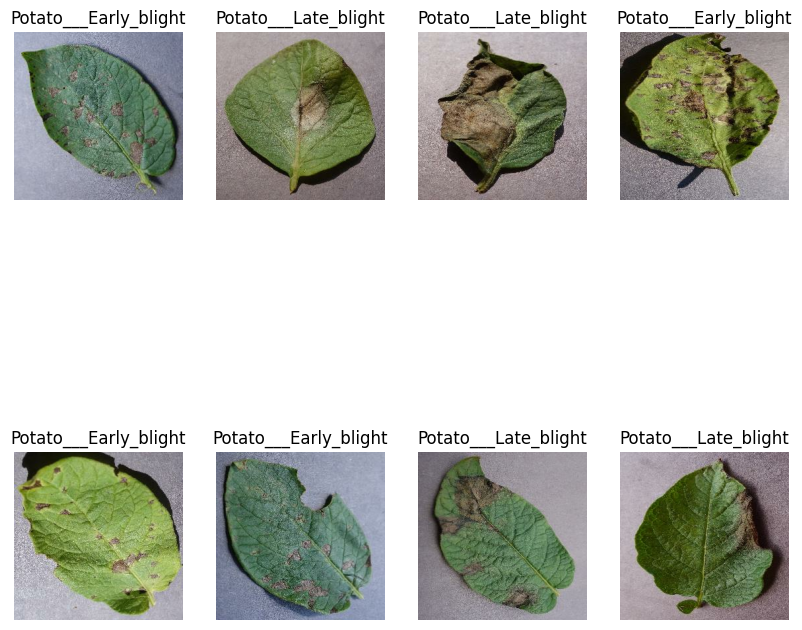

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

375

In [ ]:
train_size = 0.8
len(dataset)*train_size

300.0

In [ ]:
train_ds = dataset.take(300)
len(train_ds)

300

In [ ]:
test_ds = dataset.skip(300)
len(test_ds)

75

In [ ]:
val_size=0.1
len(dataset)*val_size

37.5

In [ ]:
val_ds = test_ds.take(37)
len(val_ds)

37

In [ ]:
test_ds = test_ds.skip(37)
len(test_ds)

38

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print("Training Dataset Size: ", len(train_ds))
print("Validation Dataset Size: ", len(val_ds))
print("Test Dataset Size: ", len(test_ds))

Training Dataset Size:  300
Validation Dataset Size:  37
Test Dataset Size:  38


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
])

In [ ]:
from tensorflow.keras.applications import ResNet50V2

IMAGE_SIZE = 256
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 50
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

base_model = ResNet50V2(include_top = False, weights = 'imagenet', input_shape = input_shape)

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    resize_and_rescale,
    base_model,

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 24,090,115
Trainable params: 525,315
Non-trainable params: 23,564,800
____________________________________

In [ ]:
model.compile(
    optimizer='rmsprop',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
300/300 [==============================] - 131s 329ms/step - loss: 1.0198 - accuracy: 0.8804 - val_loss: 0.4431 - val_accuracy: 0.9291
Epoch 2/50
300/300 [==============================] - 30s 100ms/step - loss: 0.4092 - accuracy: 0.9283 - val_loss: 0.7242 - val_accuracy: 0.8345
Epoch 3/50
300/300 [==============================] - 29s 97ms/step - loss: 0.3383 - accuracy: 0.9300 - val_loss: 0.2315 - val_accuracy: 0.9527
Epoch 4/50
300/300 [==============================] - 29s 97ms/step - loss: 0.2760 - accuracy: 0.9467 - val_loss: 0.2041 - val_accuracy: 0.9696
Epoch 5/50
300/300 [==============================] - 30s 101ms/step - loss: 0.2406 - accuracy: 0.9467 - val_loss: 0.3977 - val_accuracy: 0.8784
Epoch 6/50
300/300 [==============================] - 30s 99ms/step - loss: 0.2263 - accuracy: 0.9513 - val_loss: 0.1784 - val_accuracy: 0.9764
Epoch 7/50
300/300 [==============================] - 30s 100ms/step - loss: 0.2025 - accuracy: 0.9558 - val_loss: 0.2013 - val_accu

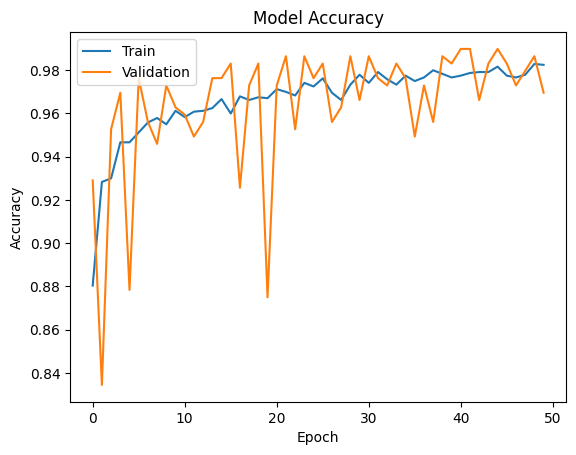

In [ ]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
except NameError:
    print("Variable 'history' is not defined. Please make sure you have executed the cell that defines this variable.")

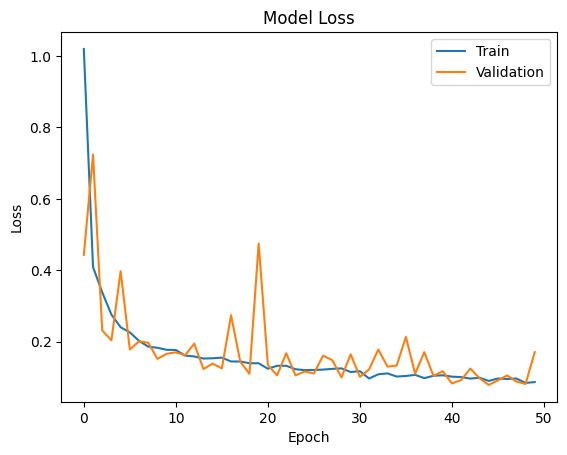

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

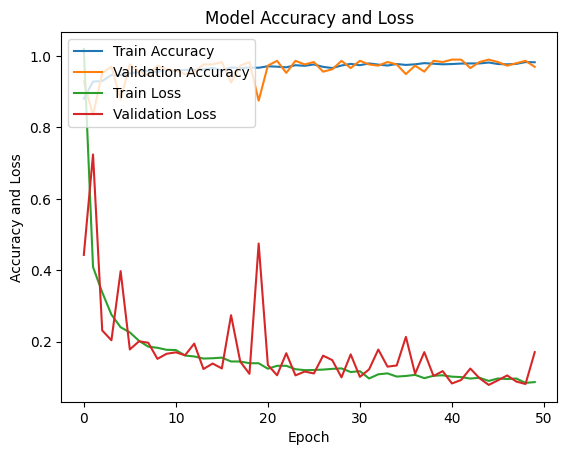

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(test_ds)

history.params

history.history['accuracy']

38/38 [==============================] - 11s 112ms/step - loss: 0.1324 - accuracy: 0.9671


[0.8804166913032532,
 0.9283333420753479,
 0.9300000071525574,
 0.9466666579246521,
 0.9466666579246521,
 0.9512500166893005,
 0.9558333158493042,
 0.9579166769981384,
 0.9549999833106995,
 0.9612500071525574,
 0.9583333134651184,
 0.9608333110809326,
 0.9612500071525574,
 0.9624999761581421,
 0.9666666388511658,
 0.9599999785423279,
 0.9679166674613953,
 0.9662500023841858,
 0.9674999713897705,
 0.9670833349227905,
 0.9712499976158142,
 0.9700000286102295,
 0.9683333039283752,
 0.9741666913032532,
 0.9725000262260437,
 0.9762499928474426,
 0.9695833325386047,
 0.9662500023841858,
 0.9733333587646484,
 0.9779166579246521,
 0.9741666913032532,
 0.9791666865348816,
 0.9758333563804626,
 0.9733333587646484,
 0.9775000214576721,
 0.9750000238418579,
 0.9766666889190674,
 0.9800000190734863,
 0.9783333539962769,
 0.9766666889190674,
 0.9775000214576721,
 0.9787499904632568,
 0.9791666865348816,
 0.9791666865348816,
 0.9816666841506958,
 0.9775000214576721,
 0.9766666889190674,
 0.9779166579

In [ ]:
history.history['val_accuracy']

[0.9290540814399719,
 0.8344594836235046,
 0.9527027010917664,
 0.9695945978164673,
 0.8783783912658691,
 0.9763513803482056,
 0.9560810923576355,
 0.9459459185600281,
 0.9729729890823364,
 0.962837815284729,
 0.9594594836235046,
 0.9493243098258972,
 0.9560810923576355,
 0.9763513803482056,
 0.9763513803482056,
 0.9831081032752991,
 0.9256756901741028,
 0.9729729890823364,
 0.9831081032752991,
 0.875,
 0.9729729890823364,
 0.9864864945411682,
 0.9527027010917664,
 0.9864864945411682,
 0.9763513803482056,
 0.9831081032752991,
 0.9560810923576355,
 0.962837815284729,
 0.9864864945411682,
 0.9662162065505981,
 0.9864864945411682,
 0.9763513803482056,
 0.9729729890823364,
 0.9831081032752991,
 0.9763513803482056,
 0.9493243098258972,
 0.9729729890823364,
 0.9560810923576355,
 0.9864864945411682,
 0.9831081032752991,
 0.9898648858070374,
 0.9898648858070374,
 0.9662162065505981,
 0.9831081032752991,
 0.9898648858070374,
 0.9831081032752991,
 0.9729729890823364,
 0.9797297120094299,
 0.9864

In [ ]:
history.history['loss']

[1.0197829008102417,
 0.40923890471458435,
 0.3383369743824005,
 0.2760055959224701,
 0.2405543029308319,
 0.2262754887342453,
 0.2024783343076706,
 0.18628738820552826,
 0.1830715835094452,
 0.17737087607383728,
 0.17679522931575775,
 0.16138654947280884,
 0.15880240499973297,
 0.15293662250041962,
 0.1538226157426834,
 0.15549130737781525,
 0.14477679133415222,
 0.14465731382369995,
 0.1398783028125763,
 0.13971996307373047,
 0.12443794310092926,
 0.1326073259115219,
 0.13271011412143707,
 0.12309518456459045,
 0.1205177828669548,
 0.12088076025247574,
 0.12201633304357529,
 0.12408041954040527,
 0.12538796663284302,
 0.11522748321294785,
 0.11756788939237595,
 0.09718289971351624,
 0.10883089900016785,
 0.11142097413539886,
 0.10250572115182877,
 0.10419677197933197,
 0.107274129986763,
 0.09804273396730423,
 0.10475265234708786,
 0.10607212781906128,
 0.1022283062338829,
 0.10102653503417969,
 0.09691067039966583,
 0.09919460862874985,
 0.09031540155410767,
 0.09714990854263306,
 0

In [ ]:
history.history['val_loss']

[0.4431345760822296,
 0.7242425680160522,
 0.23152869939804077,
 0.20410190522670746,
 0.3976946771144867,
 0.17837968468666077,
 0.20130208134651184,
 0.19718244671821594,
 0.15212717652320862,
 0.16629791259765625,
 0.17031148076057434,
 0.1622016280889511,
 0.1947471648454666,
 0.12365563958883286,
 0.13898320496082306,
 0.12527276575565338,
 0.2743365168571472,
 0.14428205788135529,
 0.11019443720579147,
 0.47489073872566223,
 0.13494877517223358,
 0.10609573125839233,
 0.16788899898529053,
 0.10584401339292526,
 0.11658423393964767,
 0.11120779812335968,
 0.1610250174999237,
 0.14847886562347412,
 0.10020990669727325,
 0.1646622270345688,
 0.10162223875522614,
 0.12262540310621262,
 0.17823214828968048,
 0.13027267158031464,
 0.13349489867687225,
 0.21364134550094604,
 0.11024860292673111,
 0.17099224030971527,
 0.10415951907634735,
 0.11770128458738327,
 0.08317482471466064,
 0.0928165391087532,
 0.12495012581348419,
 0.09785087406635284,
 0.07911044359207153,
 0.0919187068939209

In [ ]:
print("Accuracy: ", scores[1])
print("Loss: ", scores[0])

Accuracy:  0.9671052694320679
Loss:  0.13235555589199066


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

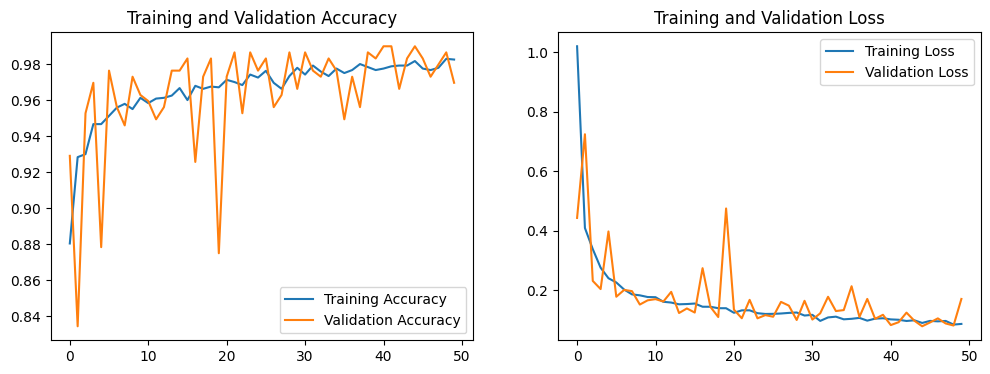

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
First image actual label: Potato___Early_blight
1/1 [==============================] - 3s 3s/step
[9.9982482e-01 1.7521901e-04 5.4898419e-09]
Max Value: 0
Predicted Label: Potato___Early_blight


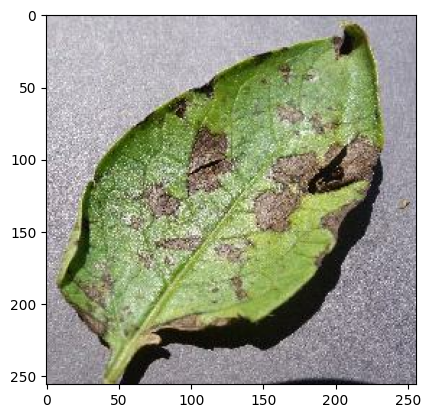

In [ ]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0]
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])
    print("Max Value:", np.argmax(batch_prediction[0]))
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 74ms/step


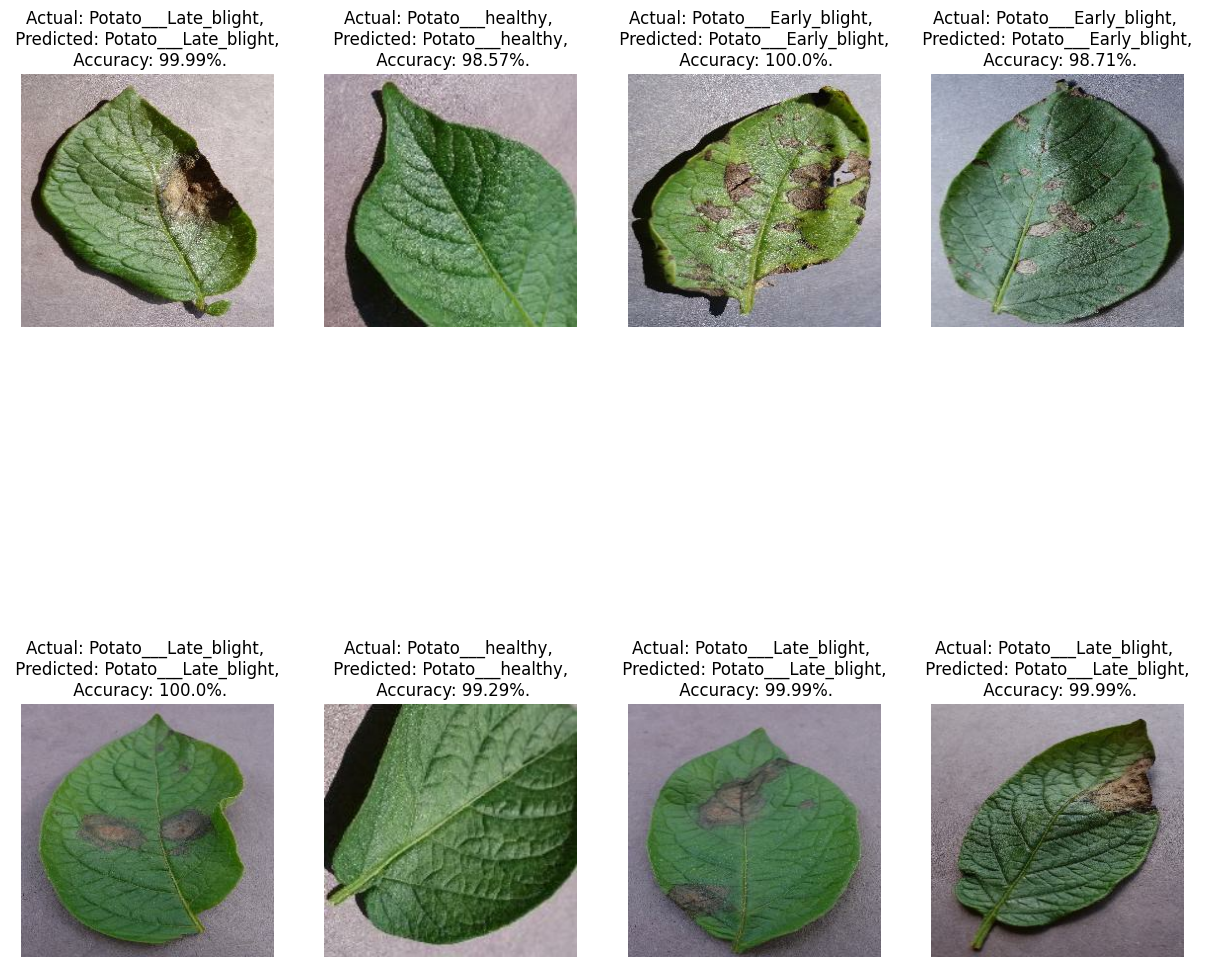

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Accuracy: {confidence}%.")  # Setting the title with actual class, predicted class, and confidence
        plt.axis("off")

In [ ]:
print("Accuracy: ", scores[1] * 100)

Accuracy:  96.71052694320679


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

f1 = f1_score(y_true, y_pred, average='weighted') * 100
precision = precision_score(y_true, y_pred, average='weighted') * 100
recall = recall_score(y_true, y_pred, average='weighted') * 100

print("F1 Score: ", f1)
print("Precision Score: ", precision)
print("Recall Score: ", recall)

38/38 [==============================] - 6s 98ms/step
F1 Score:  31.88437185952293
Precision Score:  31.94007939789926
Recall Score:  31.907894736842106


38/38 [==============================] - 4s 94ms/step


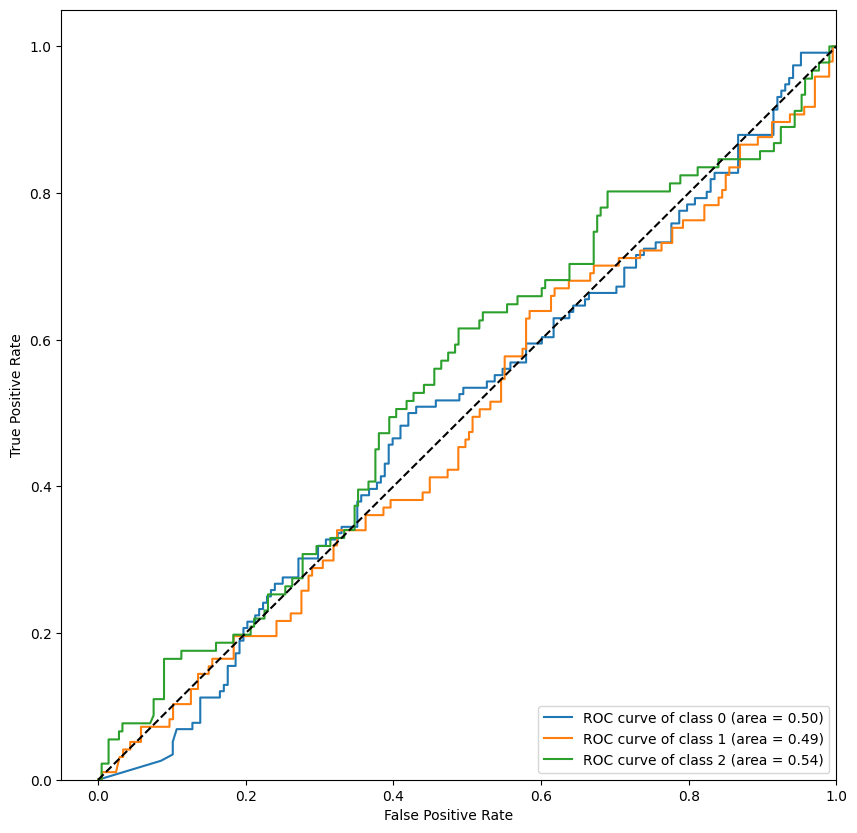

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test = label_binarize(y_true, classes=[0, 1, 2])
y_pred = model.predict(test_ds)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {i} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

38/38 [==============================] - 4s 94ms/step


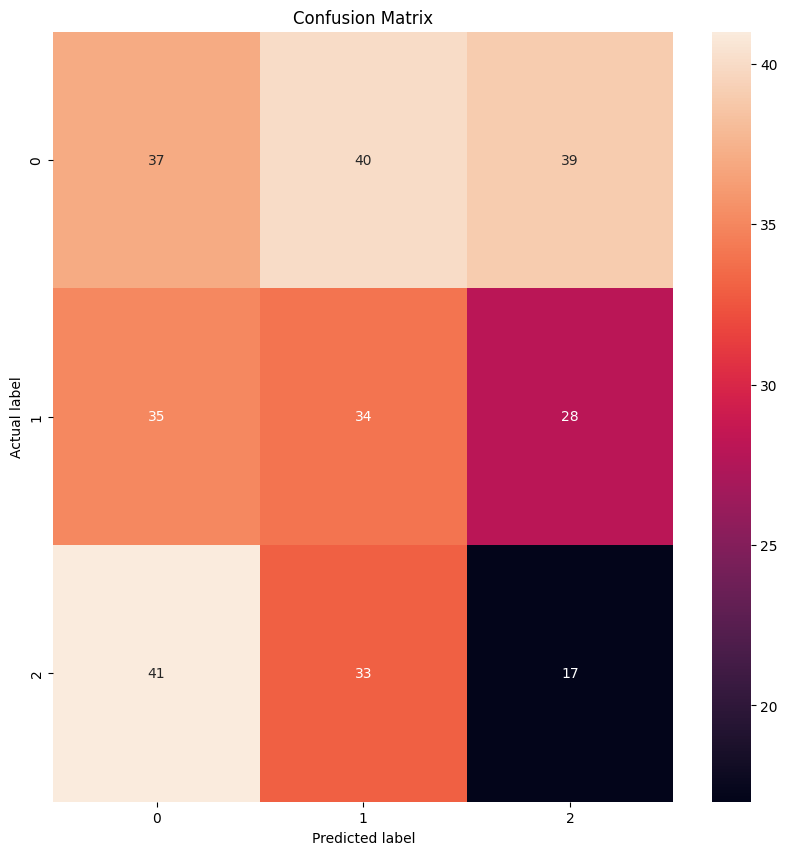

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Clear the TensorFlow session
tf.keras.backend.clear_session()